# Modeling Extremes - Numpyro Pt 3 - VI

In [1]:
import autoroot
import pandas as pd
from scipy.stats import genextreme
import numpy as np
import xarray as xr
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from tensorflow_probability.substrates.jax import distributions as tfd
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [2]:
from bayesevt._src.data.local import DATASET_SPAIN_ANOMALIES

ds = xr.open_mfdataset(DATASET_SPAIN_ANOMALIES["t2max"])

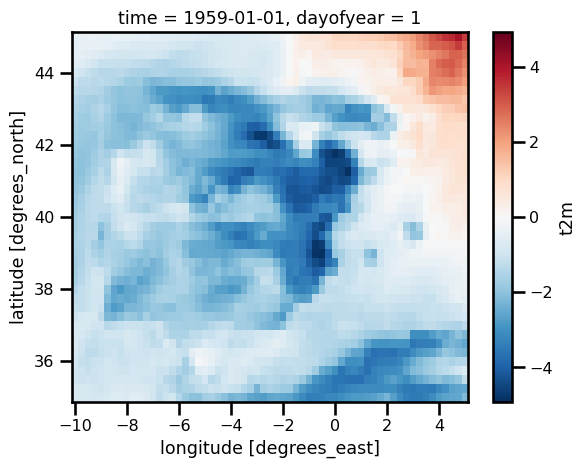

In [3]:
ds.t2m.isel(time=0).plot.pcolormesh()

## Masking

In [4]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask


In [5]:
ds = add_country_mask(ds, country="Spain")
ds = add_land_mask(ds)

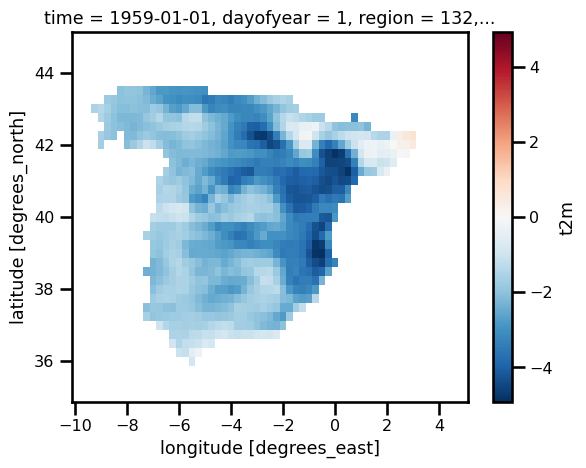

In [6]:

ds.where(ds.spain_mask==1).isel(time=0).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [7]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [8]:
# # take weighted spatial mean
# weights = ds["spain_mask"] * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [9]:

# # convert Kelvin to Celcius
# data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
data.describe()

count    23011.000000
mean        -0.382247
std          3.740105
min        -16.210242
25%         -2.915719
50%         -0.283981
75%          2.215052
max         12.947272
Name: t2m, dtype: float64

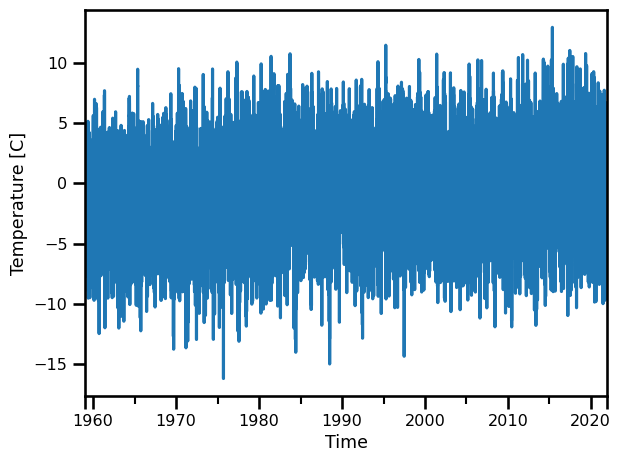

In [10]:
fig, ax = plt.subplots()

data.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Temperature [C]"
)
plt.tight_layout()
plt.show()

## Extremes

In [11]:
extremes_method = "BM"
block_size = "365.2425D" #
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

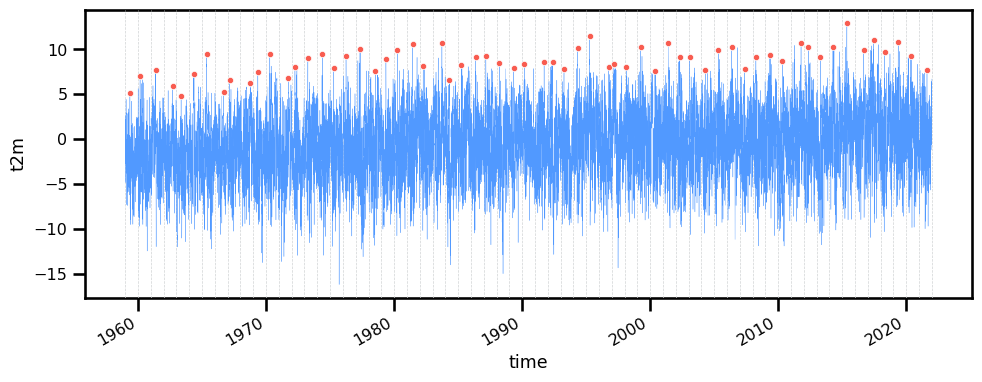

In [12]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

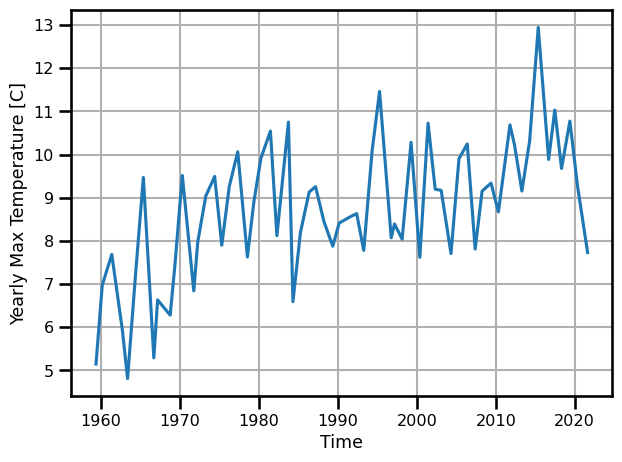

In [13]:
fig, ax = plt.subplots()

ax.plot(extremes)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()

## Model

We factoized the **Joint Distribution** as so:

$$
p(y,\boldsymbol{\theta}) = p(\boldsymbol{\theta})\prod_{n=1}^N p(y_n|\boldsymbol{\theta})
$$

### Prior & Likelihood

We do a uniform prior for the parameters.

$$
p(\boldsymbol{\theta}) = U(-\infty, \infty)
$$

We use the GEVD for the likelihood.

$$
p(y) \sim \text{GEVD}(\boldsymbol{\theta})
$$

where $\boldsymbol{\theta}=\{\mu,\sigma,\xi\}$ are the location, scale and shape parameters.

In [14]:


def model(y: Float[Array, "N"]=None):
    # prior parameters
    loc = numpyro.sample("loc", dist.Normal(0.0, 1.0))
    scale = numpyro.sample("scale", dist.LogNormal(0.0, 10.0))
    concentration = numpyro.sample("concentration", dist.LogNormal(0.0, 1.0))
    
    # likelihood
    numpyro.sample("obs", tfd.GeneralizedExtremeValue(loc, scale, concentration), obs=y)

In [15]:
rng_key = jrandom.PRNGKey(123)

### Variational Distribution

In [16]:
from numpyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal

guide = AutoMultivariateNormal(model)
# guide = AutoDiagonalNormal(model)

### Inference

$$
\boldsymbol{\phi}^* = 
\underset{\boldsymbol{\phi}}{\text{argmin}}
\hspace{2mm}
\text{ELBO}_{q}
\left[q(\boldsymbol{\theta};\boldsymbol{\phi}), p(y,\boldsymbol{\theta})\right]
$$

In [17]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [18]:
num_steps = 10_000
y = extremes.values
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

svi_result = svi.run(rng_key=rng_key_train, num_steps=num_steps, y=y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2329.29it/s, init loss: 295.2827, avg. loss [9501-10000]: 167.3778]


### Training

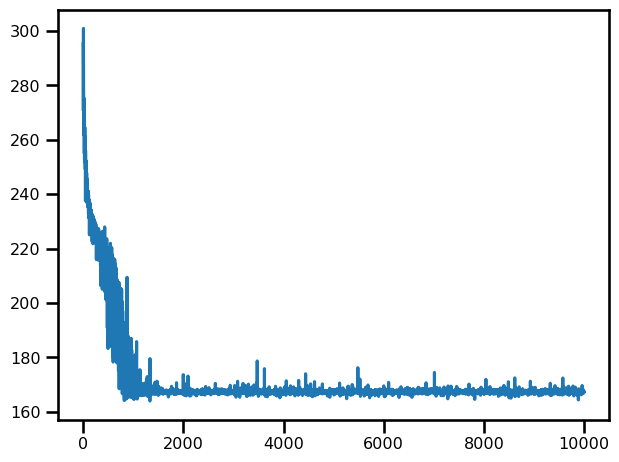

In [19]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
plt.tight_layout()
plt.show()

### Params

In [20]:
svi_result.params

{'auto_loc': Array([ 7.478523  ,  0.48695582, -2.6059723 ], dtype=float32),
 'auto_scale_tril': Array([[ 0.23439984,  0.        ,  0.        ],
        [ 0.0214502 ,  0.08919707,  0.        ],
        [-0.02948486,  0.04269706,  0.48917162]], dtype=float32)}

We notice that these variable names are not the same as the names we prescribed. 
This is because these are the parameters of the variational distribution, **not** the model.
So we need to do some extra to be able to get the proper parameters.

We can use the `Predictive` inference helper from the `numpyro` library.
In this case, we only need 1 sample because we have a simple guide.

In [21]:
params = svi_result.params
# samples = guide.get_posterior(params)
predictive = Predictive(guide, params=params, num_samples=1000)
posterior_samples = predictive(jrandom.PRNGKey(0), return_sites=["concentration"])
# posterior_samples

Now, we can extract the true parameters.

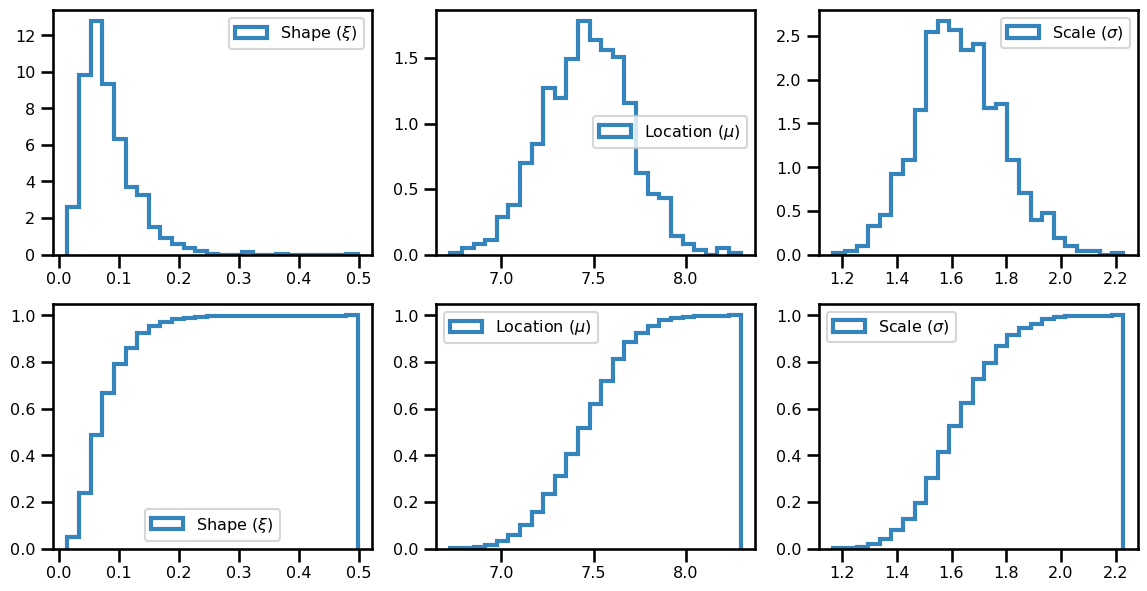

In [22]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,7))


ax[0,0].hist(posterior_samples["concentration"], 
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=False, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Shape ($\xi$)",
           
)
ax[0,1].hist(posterior_samples["loc"], 
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=False, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Location ($\mu$)"
)
ax[0,2].hist(posterior_samples["scale"],
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=False, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Scale ($\sigma$)"
)

ax[1,0].hist(posterior_samples["concentration"], 
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=True, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Shape ($\xi$)",
           
)
ax[1,1].hist(posterior_samples["loc"], 
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=True, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Location ($\mu$)"
)
ax[1,2].hist(posterior_samples["scale"],
           bins=25, rwidth=2, alpha=0.9, 
           cumulative=True, density=True, 
           color="tab:blue", linewidth=3, histtype="step", label=r"Scale ($\sigma$)"
)


ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,2].legend()
plt.show()

In [23]:
print("Parameters (MLE):")
print(f"Shape - ξ: {np.mean(posterior_samples['concentration']):.4f}")
print(f"Loc   - μ: {np.mean(posterior_samples['loc']):.4f}")
print(f"Scale - σ: {np.mean(posterior_samples['scale']):.4f}")

Parameters (MLE):
Shape - ξ: 0.0837
Loc   - μ: 7.4654
Scale - σ: 1.6337


## Return Period

In [24]:
import numpy as np
from scipy.stats import genextreme
from jax.debug import print as jprint

# simple return periods
return_periods = np.logspace(-0.999, 2, 100)

def calculate_return_levels(params):
    model = tfd.GeneralizedExtremeValue(
        loc=params["loc"], 
        scale=params["scale"], 
        concentration=params["concentration"]
    )
    return model.quantile(1-1/return_periods)

In [25]:
out = jax.vmap(calculate_return_levels)(posterior_samples)

In [26]:
ciu, mu, cil = np.quantile(out, q=[0.025, 0.5, 0.975], axis=0)

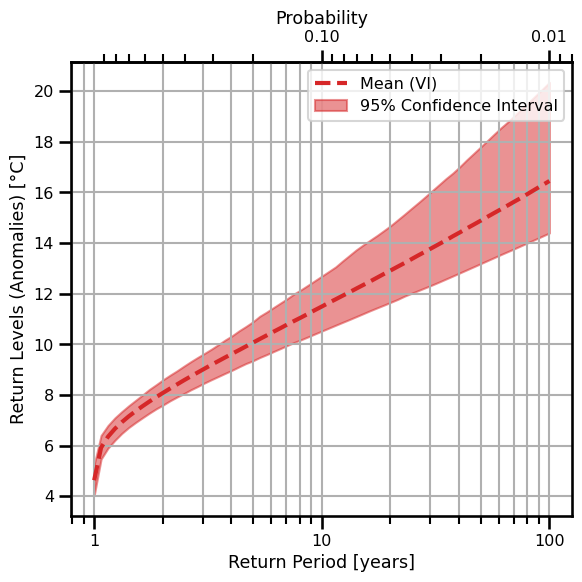

In [27]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    return_periods, mu, 
    linestyle="--", linewidth=3, color="tab:red",
    label="Mean (VI)",
)

ax.fill_between(
    return_periods, 
    cil, ciu,
    alpha=0.5,
    color="tab:red",
    label="95% Confidence Interval",
)


ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels (Anomalies) [°C]",
    xscale="log",
)

# SECOND AXIS
def safe_reciprocal(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x, float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = np.reciprocal(x[~near_zero])
    return x

secax = ax.secondary_xaxis("top", functions=(safe_reciprocal, safe_reciprocal))
secax.set_xlabel("Probability")
secax.set_xticks([0.1, 0.01])

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
secax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()